# Final pipeline for ViT-for-Facial-recognition

Set up device agnoitic code

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Regular imports

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Set up path to Data

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "CELEBRITY-FACE-RECOGNITION-DATASET"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")


data\CELEBRITY-FACE-RECOGNITION-DATASET directory exists.


Set up dirs

In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Dataset and DataLoaders

### Creating transforms for our model

We must follow the weights that are mentioned and are required for our chosen model, `vit_b_32` from `torchvision.models`

Hence, for the `vit_b_32` we will take `ViT_B_32_Weights.DEFAULT`

In [7]:
# Get a set of pretrained model weights
weights = torchvision.models.ViT_B_32_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ViT_B_32_Weights.IMAGENET1K_V1

## Data Preprocess (According to model `vit_b_32`

Now, we will use the predefined transforms associated with `ViT_B_32_Weights.DEFAULT` to preprocess our data using the `transforms()` method

In [8]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## Create Dataset

Convert our image data into a dataset (tensors) that can be accessed and understood by our model

In [9]:
train_data = datasets.ImageFolder(train_dir, transform=auto_transforms)
test_data = datasets.ImageFolder(test_dir, transform=auto_transforms)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1726
     Root location: data\CELEBRITY-FACE-RECOGNITION-DATASET\train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ),
 Dataset ImageFolder
     Number of datapoints: 646
     Root location: data\CELEBRITY-FACE-RECOGNITION-DATASET\test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ))

## Create DataLoaders


To make our dataset iterable

In [10]:
# Create training and testing DataLoaders as well as get a list of class names
BATCH_SIZE = 32

train_dataloader = DataLoader(
      dataset=train_data,
      batch_size=BATCH_SIZE,
      shuffle=True,
      num_workers=os.cpu_count(),
)
test_dataloader = DataLoader(
      dataset=test_data,
      batch_size=BATCH_SIZE,
      shuffle=False, # don't need to shuffle test data
      num_workers=os.cpu_count(),
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x217f3db6ee0>,
 <torch.utils.data.dataloader.DataLoader at 0x217f3db6eb0>)

## Getting a pre-trained model (`vit_b_32`)

In [11]:
weights = torchvision.models.ViT_B_32_Weights.DEFAULT 
model = torchvision.models.vit_b_32(weights=weights).to(device)

### Classical Model summary

In [12]:
from torchinfo import summary

summary(model=model, 
        input_size=(BATCH_SIZE, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

C:\Users\User\.conda\envs\cuda_test\lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 7, 7]      2,360,064            True
├─Encoder (encoder)                                          [32, 50, 768]        [32, 50, 768]        38,400               True
│    └─Dropout (dropout)                                     [32, 50, 768]        [32, 50, 768]        --                   --
│    └─Sequential (layers)                                   [32, 50, 768]        [32, 50, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 50, 768]        [32, 50, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 50, 768]        [32, 50, 768

### Augmenting `model` to meet our requirements

In [13]:
# Freeze all layers except the final head (optional but recommended for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42) # To maintain same output
torch.cuda.manual_seed(42)

num_classes = len(train_data.classes)

# Replace the final classification head for your 18 classes
num_ftrs = model.heads.head.in_features
model.heads.head = nn.Linear(num_ftrs, num_classes)  # 17 output classes

### Augmented model summary

In [14]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 17]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 7, 7]      (2,360,064)          False
├─Encoder (encoder)                                          [32, 50, 768]        [32, 50, 768]        38,400               False
│    └─Dropout (dropout)                                     [32, 50, 768]        [32, 50, 768]        --                   --
│    └─Sequential (layers)                                   [32, 50, 768]        [32, 50, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 50, 768]        [32, 50, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 50, 768]        [32, 

## Train and Evaluate model

In [15]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### train step module

Defines the training loop 

In [16]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

### test step module

Defines the testing loop

In [17]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### `train()` to combine both the train step and test step in one go

In [18]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 25):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### Finally pass `model` through the `train()` to train the model and evaluate it

In [19]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1114 | train_acc: 0.3044 | test_loss: 1.6184 | test_acc: 0.4628
Epoch: 2 | train_loss: 1.4853 | train_acc: 0.5483 | test_loss: 1.3039 | test_acc: 0.5813
Epoch: 3 | train_loss: 1.2516 | train_acc: 0.6461 | test_loss: 1.1472 | test_acc: 0.6587
Epoch: 4 | train_loss: 1.0894 | train_acc: 0.6861 | test_loss: 1.0179 | test_acc: 0.7123
Epoch: 5 | train_loss: 0.9742 | train_acc: 0.7324 | test_loss: 0.9284 | test_acc: 0.7525
Epoch: 6 | train_loss: 0.8689 | train_acc: 0.7770 | test_loss: 0.8238 | test_acc: 0.7882
Epoch: 7 | train_loss: 0.8032 | train_acc: 0.7995 | test_loss: 0.7608 | test_acc: 0.7912
Epoch: 8 | train_loss: 0.7313 | train_acc: 0.8261 | test_loss: 0.7028 | test_acc: 0.8224
Epoch: 9 | train_loss: 0.6795 | train_acc: 0.8459 | test_loss: 0.6602 | test_acc: 0.8403
Epoch: 10 | train_loss: 0.6265 | train_acc: 0.8713 | test_loss: 0.6341 | test_acc: 0.8433
Epoch: 11 | train_loss: 0.5869 | train_acc: 0.8813 | test_loss: 0.6033 | test_acc: 0.8269
Epoch: 12 | train_l

## Plot Loss Curves

* Visualize training and testing performance over 25 epochs
* Will help in adressing any issues like overfitting or underfitting if it arises

In [20]:
# Check the model_0_results keys
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [21]:
from typing import Dict, List  # For type hints
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

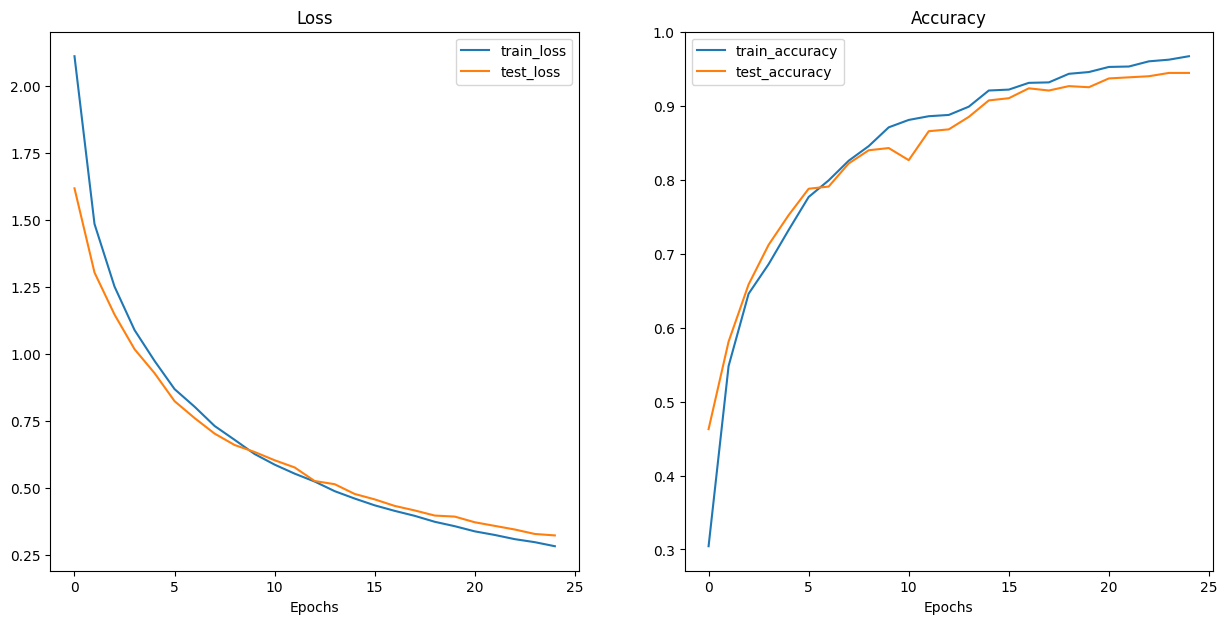

In [22]:
plot_loss_curves(model_results)